In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
path = '../data/graph_geom_corrected_cycles.csv'
csv_grafo = pd.read_csv(path, sep=';')

geometry = gpd.read_file(path, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; N = 0
for u in S:
    id_[u] = N; _id[N] = u
    N += 1

G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
        
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

T = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        T.add_edge(id_[origin], id_[dest])

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

In [3]:
get_size_weight(G, W, [0] * N, 744)

(4586, 110204.42095686684)

In [28]:
ids_orig = [13934, 14104, 13949, 15720, 13932, 13923, 14930, 131454, 15996, 15671, 13896, 14791, 15487]
ids = [13934, 14104, 13949, 15720, 13932, 13923, 14930, 16634, 15996, 15671, 15345, 14791, 15487]
tested_ids_orig = [id_[u] for u in ids_orig]
tested_ids = [id_[u] for u in ids]
tested_ids

[2149, 2319, 2164, 3929, 2150, 2140, 3141, 240, 4201, 3876, 3553, 3002, 3692]

In [29]:
tested_ids_orig = set(tested_ids_orig)
sample_orig = []

V = [0] * N

Q = deque([744])
while Q and tested_ids_orig:
    
    u = Q.popleft()
    
    if u in tested_ids_orig:
        sample_orig.append(u)
        
    for v in G.predecessors(u):
        if not V[v]:
            Q.append(v)
            V[v] = 1

print(sample_orig)

tested_ids = set(tested_ids)
sample = []

V = [0] * N

Q = deque([744])
while Q and tested_ids:
    
    u = Q.popleft()
    
    if u in tested_ids:
        sample.append(u)
        
    for v in G.predecessors(u):
        if not V[v]:
            Q.append(v)
            V[v] = 1

print(sample)

[2149, 2319, 2164, 3929, 2150, 2140, 3141, 274, 4201, 3876, 2113, 3002, 3692]
[2149, 2319, 2164, 3929, 2150, 2140, 3141, 240, 4201, 3876, 3002, 3553, 3692]


In [30]:
def visit_robust(G, V, root, u):
    
    N = len(V)
    I = get_ideal_robust(G, V, root, u)
    
    V_ = V.copy()
    for u in I:
        V_[u] = 1
    
    return V_, len(I)

In [35]:
WI = {}
V = [0] * N; VR = [0] * N
for u in sample[::-1]:
    s, w = get_size_weight(G, W, V, u)
    s, w_low = get_size_weight_robust(G, W, V, 744, u)
    s, w_high = get_size_weight(G, W, VR, u)
    WI[_id[u]] = w
    V, _ = visit(G, V, u)
    VR, _ = visit_robust(G, VR, 744, u)
    print(_id[u], ' ' * 4, round(w, 1), ' ' * 4, round(w_low, 1), ' ' * 4, round(w_high, 1), ' ' * 4, round(get_size_weight(G, W, [0] * N, u)[1], 1), ' ' * 4, round(get_size_weight_robust(G, W, [0] * N, 744, u)[1], 1))

15487      2276.7      548.4      2276.7      2276.7      548.4
15345      532.9      291.0      2261.3      2809.6      839.4
14791      6908.4      6908.4      6908.4      6908.4      6908.4
15671      5905.6      5692.0      5905.6      12813.9      12600.4
15996      10364.9      10253.2      10540.8      10540.8      10253.2
16634      13670.5      13158.2      15790.4      39659.1      39146.7
14930      4881.1      4665.7      5393.5      5393.5      4665.7
13923      3680.9      3680.9      3896.4      9074.4      8562.0
13932      8696.6      7428.6      8696.6      8696.6      7428.6
15720      13999.8      12752.6      13999.8      13999.8      12752.6
13949      8502.0      8502.0      9770.0      9770.0      8502.0
14104      8581.6      8581.6      8581.6      8581.6      8581.6
13934      22203.2      22203.2      23450.4      110204.4      110204.4


In [32]:
def plot_sample_no_intersections(G, V_, sample, geom, _id, name):
    
    geometry = geom.copy(); N = len(V_)
    
    V = V_.copy()
    
    I = []; C = [-1 * V[u] for u in range(N)]
    for u in sample:
        I.append(get_ideal(G, V, u))
        V, _ = visit(G, V, u)
    
    for i in range(len(I)):
        for u in I[i]:
            C[u] = i + 1
            
    newC = list(range(len(sample)))
    random.shuffle(newC)
    for u in range(N):
        if C[u] > 0:
            C[u] = newC[C[u] - 1] + 1
            
    newC_ = [0] * len(newC)
    for i in range(len(newC)):
        newC_[newC[i]] = i

    # Marcamos los elementos visitados en geometry
    geometry['color'] = -1
    for u in range(N):
        geometry.loc[geometry['self'] == str(_id[u]) , 'color'] = C[u]
            
    # Graficamos puntos de testeo
    coord = points_coordinates(sample, geometry, _id)
    
    for i in range(len(coord)):
        coord[i] = coord[i].buffer(100)
    
    for i in range(len(coord)):
        geometry.loc[geometry.shape[0] + i + 1] = ['a'] + ["b"] + [3] + [1] + [coord[i]] + [newC[i] + 1]

    label_ids = "   ".join([f"{i + 1}: {_id[sample[newC_[i]]]}" for i in range(len(sample))])
        
    # Graficamos
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Resultados de testeo", fontsize=25)
    ax = geometry.plot(ax = ax, column = 'color',
                       figsize=(15, 15),
                       legend = True,
                       legend_kwds={'label': f"-1: No considerado   0: No cubierto   "+ label_ids, 'orientation': "horizontal"},
                       cmap = 'nipy_spectral',)
    plt.savefig(f"{name}.pdf", dpi=1000)

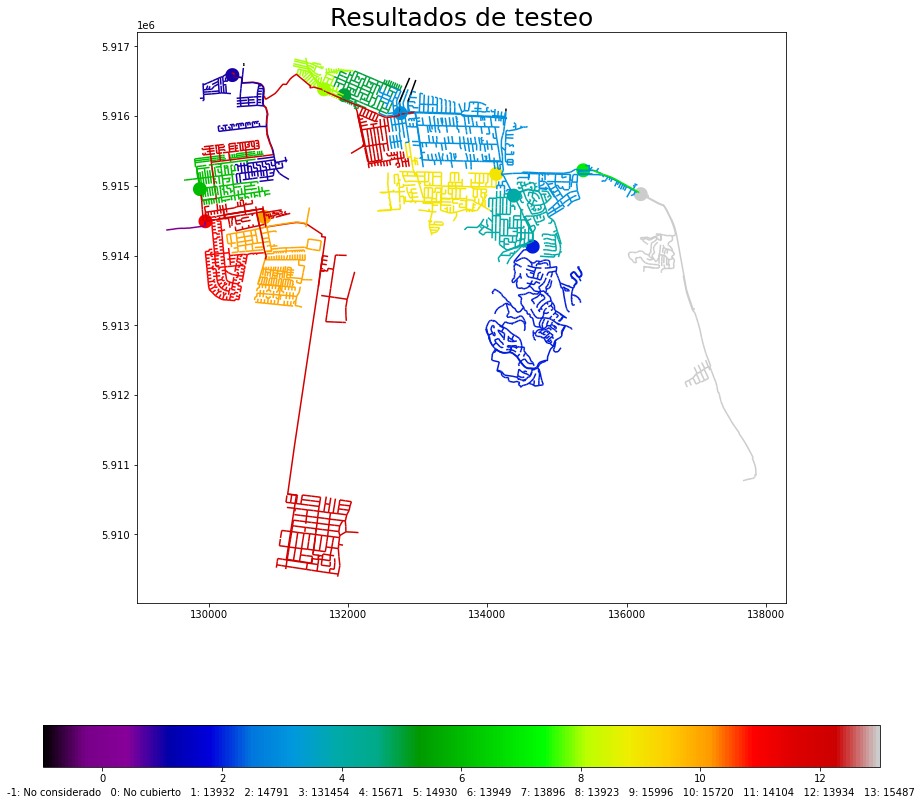

In [33]:
plot_sample_no_intersections(G, [0] * N, sample_orig[::-1] , geometry, _id, "map_orig")

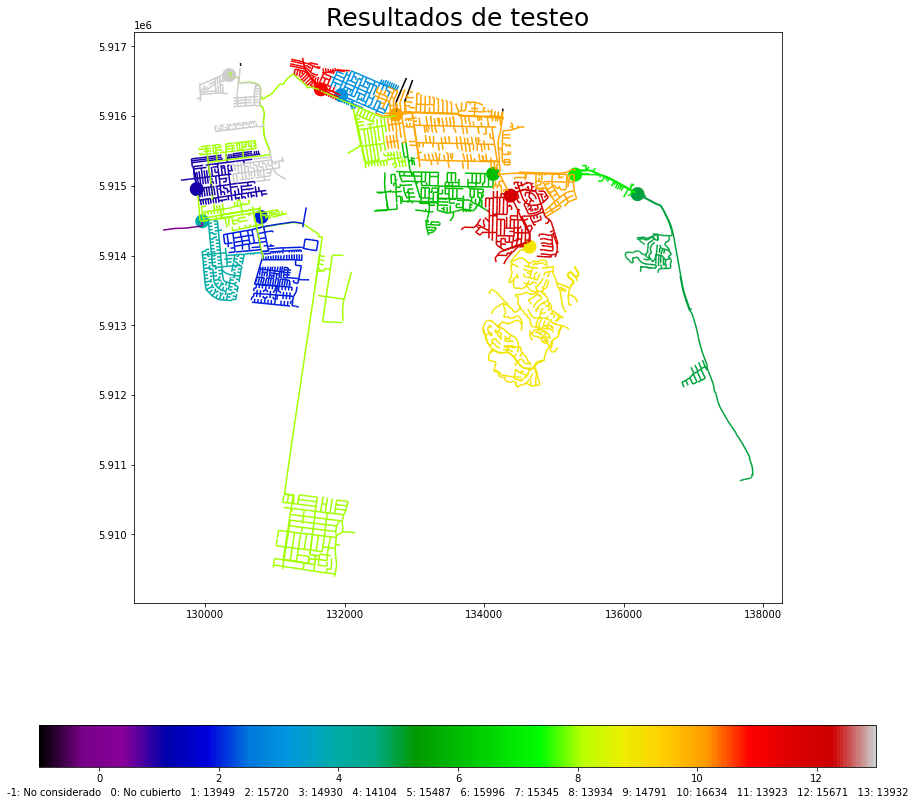

In [34]:
plot_sample_no_intersections(G, [0] * N, sample[::-1] , geometry, _id, "map_changes")

In [8]:
DG = nx.DiGraph()

ss = set(sample)

for r in sample:
    
    V = [0] * N
    
    Q = deque([r])
    while Q:
        
        u = Q.popleft()
        
        for v in G.predecessors(u):
            if not V[v] and v not in ss:
                Q.append(v)
                V[v] = 1
            if not V[v] and v in ss:
                DG.add_edge(_id[r], _id[v])
                V, _ = visit(G, V, v)

In [9]:
print(DG.edges())

[(13934, 14104), (13934, 13949), (13934, 15720), (13934, 13932), (13934, 13923), (13934, 16634), (13923, 14930), (16634, 15996), (16634, 15671), (16634, 15345), (15671, 14791), (15345, 15487)]


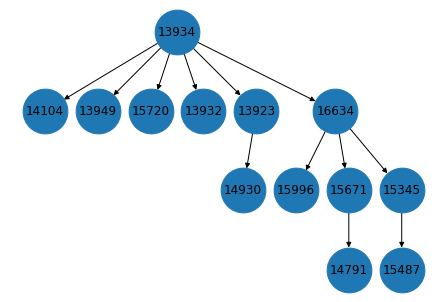

In [10]:
pos = graphviz_layout(DG, prog="dot")
nx.draw(DG, pos, with_labels=True, node_size=2000)
plt.savefig("tree")

In [11]:
P = {
    15671: 0, 
    13934: 4800, 
    13896: 303, 
    13923: 401.65, 
    13949: 283.38, 
    15996: 0,
    14104: 99.5,
    13932: 4740,
    14930: 470, 
    15487: 7530,
    15720: 1030
    }

In [12]:
Vals = {_id[u]: P[_id[u]] * get_size_weight(G, W, [0] * N, u)[1] for u in sample[::-1]}

KeyError: 15345

In [ ]:
for u in sample:
    for v in DG.successors(_id[u]):
        if Vals[_id[u]] < Vals[v]:
            print("ERROR")
            print(_id[u], v, Vals[_id[u]], Vals[v])

In [17]:
t = id_[13934]
u = id_[14104]; v = id_[13207]
print((t, v) in G.edges)

False


In [18]:
print(G.edges)

[(4583, 5), (5, 4), (4562, 4574), (4574, 4487), (4487, 12), (4487, 4568), (12, 11), (11, 2294), (2294, 4), (26, 43), (43, 42), (4578, 4579), (4579, 2288), (4558, 4562), (4, 3), (4572, 4573), (4573, 4583), (2781, 4583), (4568, 4571), (4571, 4583), (102, 106), (106, 2295), (103, 105), (105, 106), (0, 1), (1, 4), (4585, 0), (15, 16), (16, 18), (18, 28), (94, 86), (94, 18), (86, 87), (91, 92), (92, 93), (90, 91), (3, 107), (2, 3), (24, 25), (24, 18), (25, 19), (17, 24), (4569, 4570), (4570, 4571), (4565, 4569), (4555, 4565), (4566, 4567), (4567, 4573), (13, 12), (4564, 4565), (4554, 4566), (101, 2293), (101, 2294), (2293, 11), (2285, 2781), (2780, 2781), (93, 94), (93, 16), (4496, 4495), (4495, 159), (4497, 4496), (4498, 4499), (4499, 1731), (4557, 2285), (235, 101), (14, 2291), (2291, 15), (2290, 15), (21, 92), (4577, 124), (124, 4574), (9, 6), (6, 5), (2289, 14), (4553, 4567), (4563, 4562), (4390, 4391), (4391, 4560), (88, 94), (89, 93), (4502, 4557), (36, 228), (36, 35), (228, 4487), (4